# MDA project: predicting crowdedness in Leuven through noise and weather data

### Importing packages

In [ ]:
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold


c:\Users\Arthur\miniconda3\envs\course_mda\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Arthur\miniconda3\envs\course_mda\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

### Loading data and adding time-related features

In [ ]:
final_df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
final_df['result_timestamp'] = pd.to_datetime(final_df['result_timestamp'], format='%Y-%m-%d %H:%M:%S')

Perform 80-20 split

In [ ]:
#split data in first 80% and last 20%
def split8020(df):
    first80 = int(len(df) * 0.8)
    last20 = int(len(df) * 0.8)
    df_first80 = df.iloc[:first80,]
    df_last20 = df.iloc[last20:,]

    return df_first80, df_last20

final_df_first80, final_df_last20 = split8020(final_df)

### Exploratory data analyses on train/validation set (first 80%)

Preprocessing pipeline: delaying noise and weather

In [ ]:
#Select only 3 locations close to Oude Markt
final_df_first80 = final_df_first80[final_df_first80['object_id']<255442]
final_df_last20 = final_df_last20[final_df_last20['object_id']<255442]

In [ ]:
#create feature matrix with delayed noise and weather data, as well as target vector.

def delay_noise_weather(df):
    # Select columns for df_noisedelay
    df_noisedelay = df.loc[:, ['object_id', 'result_timestamp', 'laeq']]
    df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
    df_noisedelay= df_noisedelay.drop('laeq',axis=1)
    
    # Add 6 hours to result_timestamp
    df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_noisedelay = df_noisedelay.drop(['object_id', 'result_timestamp'], axis=1)

    # Select columns for df_weatherdelay
    df_weatherdelay = df.loc[:, ['object_id', 'result_timestamp', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                          'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]

    # Add 6 hours to result_timestamp
    df_weatherdelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_weatherdelay['key'] = df_weatherdelay['object_id'].astype(str) + df_weatherdelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_weatherdelay = df_weatherdelay.drop(['object_id', 'result_timestamp'], axis=1)

    #Drop weather-related columns from original df
    df = df.drop(['LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                  'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0'], axis=1)
    df['key'] = df['object_id'].astype(str) + df['result_timestamp'].astype(str)

    # Merge df with df_noisedelay and df_weatherdelay on 'key'
    delayed_df = pd.merge(df, df_noisedelay, on='key').merge(df_weatherdelay, on='key')

    # Delete observations with missing values
    delayed_df = delayed_df.dropna()

    # Create feature matrix X and target vector y
    X = delayed_df.drop(['result_timestamp', 'key','laeq', 'object_id','255442', '255443', '255444', '255445',
       '280324', '303910'], axis=1)
    y = delayed_df['laeq']

    # Return full dataframe with delays, return feature matrix X and target vector y
    return delayed_df, X, y

#Apply to df
delayed_df, X, y = delay_noise_weather(final_df_first80)
    

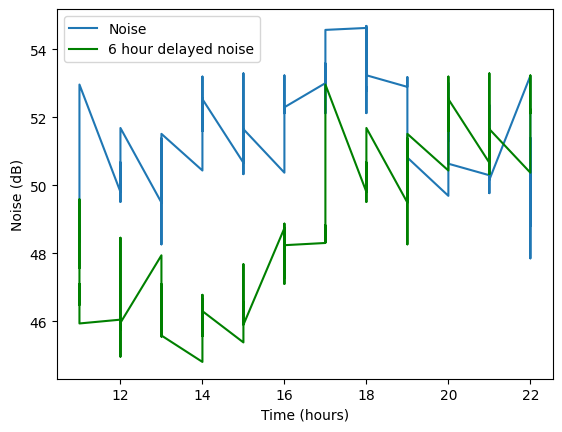

In [ ]:
#check 6 hour delay
plt.plot(delayed_df['hour'][30:100], y[30:100], label = 'Noise')
plt.plot(delayed_df['hour'][30:100], X['laeq_delayed'][30:100], color='g', label='6 hour delayed noise')
plt.xlabel('Time (hours)')
plt.ylabel('Noise (dB)')
plt.legend()
plt.show()

### Pipelines to fit all models (with cross-validation and hyperparameter tuning)

Create pipeline for Ridge with spline transformations

In [ ]:
#preparing transformations and features for the Ridge regression
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

#creating spline transformers
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    #remainder=MinMaxScaler(),
)

#creating interactions
hour_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

day_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

hour_weekend_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("weekend", FunctionTransformer(lambda x: x == 1), ["weekend"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

#creating a standardization function for the numeric variables
scaling_features=['LC_HUMIDITY','LC_TEMP_QCL0','LC_RAD60','LC_WINDSPEED','LC_WINDDIR','LC_DAILYRAIN','LC_RAININ','LC_RAD','LC_n','LC_DWPTEMP']
standardize=ColumnTransformer(
    [
        ("standardization",StandardScaler(),scaling_features)
    ],
)

Evaluate different models and select best performing model

In [ ]:
# Create the pipelines
pipelines = [
    ('Ridge', Pipeline([
    ('features', FeatureUnion([
        ("marginal", cyclic_spline_transformer),
        ("interactions1", hour_weekend_interaction),
        ("interactions2", day_holiday_interaction),
        ("interactions3", hour_holiday_interaction),
        ('standardize', standardize)
    ])),
    ('model', Ridge())
    ])),
    ('Gradient Boosting', Pipeline([('model', HistGradientBoostingRegressor(random_state=1234))
    ])),
    ('XGBoost', Pipeline([('model', XGBRegressor(random_state=1234))
    ]))
]

In [ ]:
#create object for 5-fold cross validation with shuffled observations
cv = KFold(n_splits=5, shuffle=True, random_state=1234)

In [ ]:
def find_best_parameters(X, y):
    
    # Define the parameter grids for GridSearchCV
    param_grids = {
        'Ridge': {'model__alpha': np.logspace(-6, 6, 25)},

        'Gradient Boosting': {
            #n_estimators is not further increased, to limit runtime
            'model__learning_rate': [0.29,0.30],
            'model__max_leaf_nodes': [100,200]
        },

        'XGBoost': {
            #n_estimators is not further increased, to limit runtime
            'model__learning_rate': [0.09,0.10],
            'model__n_estimators': [100,200],
            'model__max_depth': [18,19]
        }
    }
    best_pipeline = None
    best_params = None
    best_score = -float('inf')

    # Perform grid search using cross-validation for each pipeline
    for pipeline_name, pipeline in pipelines:
        param_grid = param_grids[pipeline_name]
        scorer = 'neg_mean_squared_error'
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scorer)
        grid_search.fit(X, y)

        # Print the best parameters and score for the current pipeline
        print(pipeline_name, "- Best Parameters: ", grid_search.best_params_)
        score = -grid_search.best_score_
        print(pipeline_name, "- Best Score: ", score)
        print("-----")

        if grid_search.best_score_ > best_score:
            best_pipeline = pipeline
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
    
    # Set the best parameters to the best pipeline
    best_pipeline.set_params(**best_params)

    # Return the best pipeline with the best parameters
    return best_pipeline
final_pipeline=find_best_parameters(X, y)

Ridge - Best Parameters:  {'model__alpha': 0.0031622776601683794}
Ridge - Best Score:  11.824095392861462
-----
Gradient Boosting - Best Parameters:  {'model__learning_rate': 0.3, 'model__max_leaf_nodes': 300}
Gradient Boosting - Best Score:  4.165814590966898
-----
XGBoost - Best Parameters:  {'model__learning_rate': 0.1, 'model__max_depth': 19, 'model__n_estimators': 300}
XGBoost - Best Score:  3.5339403859396947
-----


In [ ]:
final_pipeline

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=19, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=1234, ...))])

In [ ]:
final_pipeline= Pipeline(
    [('model', XGBRegressor(random_state=1234,max_depth=19,learning_rate=0.1,n_estimators=200))]
    )

#plot shapley values for final model pipeline
def compute_shap_values(X,y,pipeline):
    pipeline.fit(X,y)
    explainer = shap.TreeExplainer(pipeline.steps[-1][1])
    shap_values = explainer.shap_values(X)

    return(shap_values)

shap_values=compute_shap_values(X,y,final_pipeline)

#summary plot
shap.summary_plot(shap_values, X)
#bar chart
shap.summary_plot(shap_values, X, plot_type="bar")
   
def get_important_features(shap_values,X,cutoff):
    # Calculate average absolute Shapley value for each feature
    avg_shap_values = pd.DataFrame(shap_values, columns=X.columns).abs().mean()
    sorted_features = avg_shap_values.sort_values(ascending=False)
    # Select top-k features based on the cutoff point
    selected_features = sorted_features[sorted_features >= cutoff].index.tolist()
    return selected_features, X.loc[:, selected_features]

selected_features, X_2=get_important_features(shap_values,X,0.01)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
X_2.head()

,hour,day_of_week,holiday,255441,255440,month,255439,exam_period,LC_TEMP_QCL0,weekend,LC_RAD60,LC_TEMP_QCL3,LC_RAD,LC_HUMIDITY
0,6,5,True,True,False,1,False,False,13.28,True,0.0,11.54982,0.0,91.0
1,6,5,True,True,False,1,False,False,13.28,True,0.0,11.52837,0.0,90.0
2,6,5,True,True,False,1,False,False,13.28,True,0.0,11.52966,0.0,90.0
3,6,5,True,True,False,1,False,False,13.28,True,0.0,11.55408,0.0,90.0
4,6,5,True,True,False,1,False,False,13.28,True,0.0,11.72889,0.0,90.0


Once shapley works, we should implement X_2 in cells below

In [ ]:
#create test sets
delayed_df_test, X_test, y_test = delay_noise_weather(final_df_last20)

#fit best model on train and validation data
final_pipeline.fit(X_2, y)

#create predictions for test range, using selected features only
X_test_2 = X_test.loc[:, selected_features]
best_model_predictions = final_pipeline.predict(X_test_2)

# Calculate the mean squared error
mse = mean_squared_error(y_test, best_model_predictions)
print(f"MSE = {mse}")


RMSE = 3.500217237737059


### Visualization of results of final model

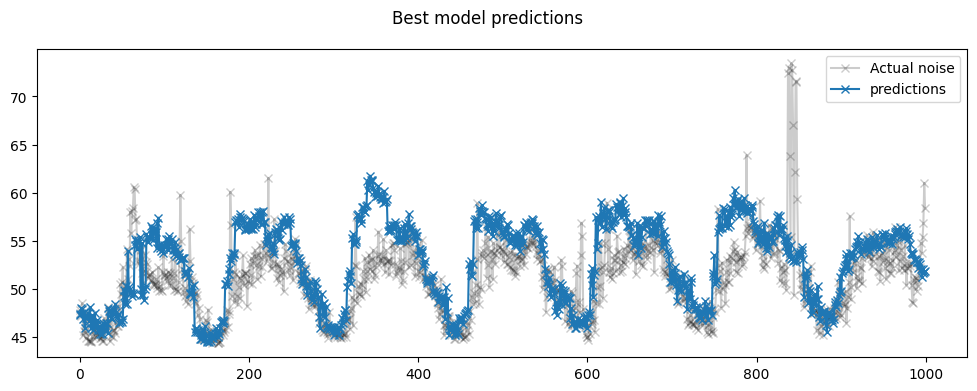

In [ ]:
#visualization of model predictions, trained on full data

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Best model predictions")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(best_model_predictions[last_hours], "x-", label="predictions")
_ = ax.legend()


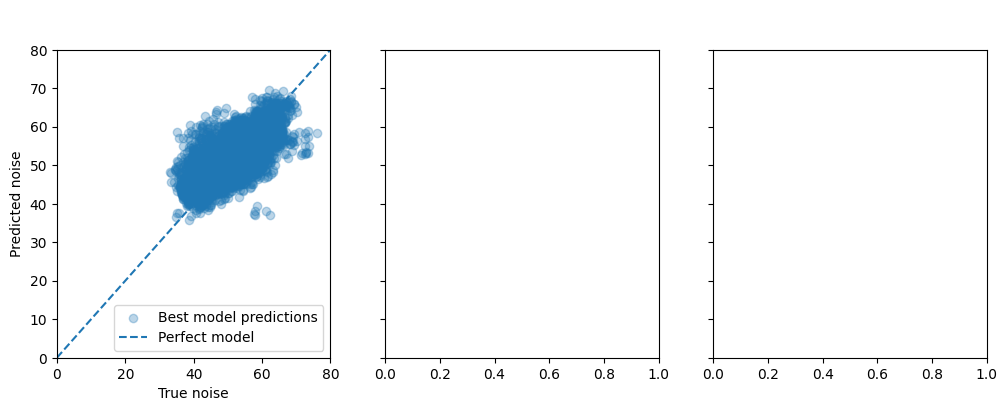

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle(" ")
predictions = [
    best_model_predictions,
]
labels = [
    "Best model predictions",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y_test.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

Shapley values

Add timestamp to predictions

In [ ]:
delayed_df_test_timestamp = pd.DataFrame(delayed_df_test['result_timestamp'])
delayed_df_test_timestamp = delayed_df_test_timestamp.reset_index()
best_model_predictions = pd.DataFrame(best_model_predictions, columns=['predictions'])
best_model_predictions = best_model_predictions.reset_index()
predictions_timestamped = pd.concat([delayed_df_test_timestamp, best_model_predictions], axis = 1)


In [ ]:
print(len(best_model_predictions))
print(len(delayed_df_test['result_timestamp']))
print(len(predictions_timestamped['result_timestamp']))

19269
19269
19269


In [ ]:
predictions_timestamped.isna().sum()

index               0
result_timestamp    0
index               0
predictions         0
dtype: int64

In [ ]:
predictions_timestamped

,index,result_timestamp,index,predictions
0,0,2022-10-28 02:00:00,0,54.756310
1,1,2022-10-28 02:10:00,1,55.310093
2,2,2022-10-28 02:20:00,2,55.048653
3,3,2022-10-28 02:30:00,3,54.868752
4,4,2022-10-28 02:40:00,4,53.701313
...,...,...,...,...
19264,19328,2022-12-31 23:10:00,19264,51.260033
19265,19329,2022-12-31 23:20:00,19265,51.671707
19266,19330,2022-12-31 23:30:00,19266,52.036686
19267,19331,2022-12-31 23:40:00,19267,51.697048


In [ ]:
predictions_timestamped = predictions_timestamped.drop('index',axis=1)

In [ ]:
averaged_pred = predictions_timestamped.groupby('result_timestamp').mean()
averaged_pred_24h = averaged_pred.iloc[132:276,]
averaged_pred_24h.reset_index(inplace=True)
averaged_pred_24h

,result_timestamp,predictions
0,2022-10-29 00:00:00,53.106190
1,2022-10-29 00:10:00,52.895596
2,2022-10-29 00:20:00,52.495392
3,2022-10-29 00:30:00,52.889721
4,2022-10-29 00:40:00,52.931183
...,...,...
139,2022-10-29 23:10:00,52.701874
140,2022-10-29 23:20:00,52.394821
141,2022-10-29 23:30:00,52.202080
142,2022-10-29 23:40:00,52.853317


In [ ]:
averaged_pred_24h.to_csv('averaged_pred_24h.csv', index=False)

Average noise as reference

In [ ]:
average_day_noise = final_df_first80
average_day_noise['time'] = average_day_noise['result_timestamp'].dt.time
average_day_noise = pd.DataFrame((average_day_noise.groupby(["time"])["laeq"].mean())).reset_index()
average_day_noise['result_timestamp'] = "2022-10-29 " + average_day_noise['time'].astype(str)
average_day_noise = average_day_noise.drop('time',axis=1)
average_day_noise


,laeq,result_timestamp
0,51.281601,2022-10-29 00:00:00
1,50.987062,2022-10-29 00:10:00
2,50.986824,2022-10-29 00:20:00
3,50.723151,2022-10-29 00:30:00
4,50.504066,2022-10-29 00:40:00
...,...,...
139,52.208609,2022-10-29 23:10:00
140,51.704090,2022-10-29 23:20:00
141,51.463757,2022-10-29 23:30:00
142,51.394389,2022-10-29 23:40:00


In [ ]:
average_day_noise.to_csv('average_day_noise.csv',index=False)

In [ ]:
X.to_csv('feature_matrix.csv', index=False)
y.to_csv('target_vector.csv', index=False)
best_model_predictions.to_csv('X_test_predictions.csv',index=False)
y_test.to_csv('y_test_values.csv',index=False)
